### 500543568_530454874_LayerVisualizer

Team members: Andrew Zhang (SID:500543568) Vincent Yunansan (SID:530454874)  

This file generates representations of layers

In [1]:
##EDA imports
import logging

#basic libraries
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

#load and counts and scores 
import os
import re
from io import StringIO
from collections import Counter
import time
from datetime import datetime
import glob
from sklearn.metrics import f1_score

#nltk for word counts in caption
import nltk
from nltk.corpus import stopwords

#images
from IPython.display import display, Image as DisplayImage
from PIL import Image

#torch
import torch
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim

from sklearn.model_selection import train_test_split

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# read train file
FILENAME = 'data/train.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    train_data = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

FILENAME = 'data/test.csv'
with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
    test_data = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [3]:
def one_hot_encode_multilabels(df, label_column):
    """
    One-hot encode a column of labels separated by spaces in a DataFrame.

    input:
    df (pd.DataFrame): The DataFrame containing the data.
    label_column (str): The name of the column containing the space-separated labels.

    output:
    pd.DataFrame: A DataFrame with the original columns plus the one-hot encoded labels.
    """
    # Check if the label column exists in DataFrame
    if label_column not in df.columns:
        raise ValueError(f"The specified column '{label_column}' does not exist in the DataFrame.")

    # Split the labels by space and apply one-hot encoding
    # We create a Series of lists of labels, then explode it to have a single label per row
    s = df[label_column].str.split().explode()

    # Convert the exploded labels into integers for proper one-hot encoding
    s = s.astype(int)

    # Get dummies and then sum back to original DataFrame shape
    dummies = pd.get_dummies(s, prefix='Label').groupby(level=0).sum()

    # Concatenate the original DataFrame with the new one-hot encoded columns
    df_encoded = pd.concat([df, dummies], axis=1)

    # Print counts for each label
    label_counts = dummies.sum()
    return df_encoded

class EarlyStopper:
    '''
    Early stopping class to stop training if the validation loss does not improve after a certain number of epochs.
    '''
    def __init__(self, patience=4, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
# for train and val data
class ImageDataset(Dataset):
    """
    Dataset object for train image data (since it has both image and label)
    input:
        dataframe (pd.DataFrame): DataFrame containing the image paths and one-hot encoded labels.
        image_dir (str): Directory where images are stored.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        label = self.dataframe.iloc[idx, 1:].values.astype('float32') 
        
        return image, label 


#for test data
class ImageDataset2(Dataset):
    """
    Dataset object for test image data (since it only has image and no label)
    input:
        dataframe (pd.DataFrame): DataFrame containing the image paths and one-hot encoded labels.
        image_dir (str): Directory where images are stored.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image
    
#logger

class Logger:
    '''
    Generate log files for analysis. This object runs in the background without user input.
    '''
    def __init__(self, model_name, timestamp, logging_path='models/logs/'):
        self.model_name = model_name
        self.timestamp = timestamp
        self.logging_path = logging_path
        os.makedirs(self.logging_path, exist_ok=True)

        # Create a custom logger
        self.logger = logging.getLogger(__name__)
        self.logger.handlers = []  # Clear existing handlers, otherwise we'll get multiple as has happened
        self.logger.setLevel(logging.INFO)

        # Create handlers
        c_handler = logging.StreamHandler()
        f_handler = logging.FileHandler(f'{self.logging_path}{self.model_name}.log')
        c_handler.setLevel(logging.INFO)
        f_handler.setLevel(logging.INFO)

        # Create formatters and add it to handlers
        c_format = logging.Formatter('%(message)s')
        f_format = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        c_handler.setFormatter(c_format)
        f_handler.setFormatter(f_format)

        # Add handlers to the logger
        self.logger.addHandler(c_handler)
        self.logger.addHandler(f_handler)

    def get_logger(self):
        return self.logger

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

#use below for cuda
'''
#load cuda to run best model
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU: cuda")
else:
    device = torch.device("cpu")
    print("Running on the CPU")
'''

print(f'device: {device}')

device: mps


In [4]:
#one hot encode train_data and drop excess columns
df_encoded = one_hot_encode_multilabels(train_data, 'Labels')
df_encoded_train = df_encoded.drop(columns=['Labels','Caption'])

#train val split
train_proportion = 0.8

dataframe = df_encoded_train
image_dir = 'data/'

# Split the dataset
train_dataset, val_dataset = train_test_split(dataframe, test_size = 1 - train_proportion, random_state = 42)

dataset classses

In [5]:
# Implement transformations on train, val, and test datasets

transform_train = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomCrop((224,224)),
    transforms.ColorJitter(brightness = 0.5),
    transforms.RandomRotation(degrees = 45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# create train, val, and test datasets
train_dataset = ImageDataset(train_dataset, image_dir, transform=transform_train)
val_dataset = ImageDataset(val_dataset, image_dir, transform=transform_val)
test_dataset = ImageDataset2(dataframe = test_data, image_dir = image_dir, transform=transform_test)

# create train, val and test dataloaders, not generator is set to None
batch_size = 32
generator2 = torch.Generator()
generator2.manual_seed(42)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=None)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, generator=None)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


#### Visualization of RegNet AdaDelta with Mix Precision

label string: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


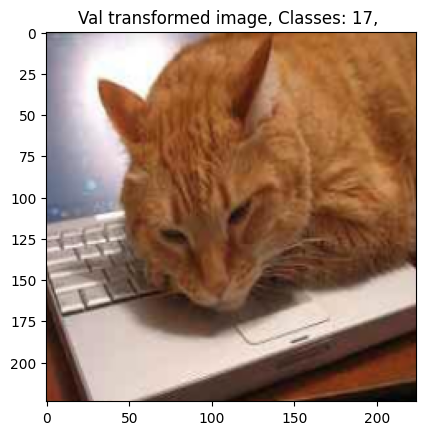

In [6]:
image_number = 4

# Get one batch of training data
images, labels = next(iter(val_loader))

# Only select one image from the batch
image_torch = images[image_number]
label = labels[image_number]


# Since the images are normalized, we need to denormalize to plot them
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
image = image_torch.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
image = image * std + mean  # Denormalize
image = image.numpy()

print(f'label string: {label}')

# Create the title string
title = 'Val transformed image, Classes: '
for i, class_value in enumerate(label):
    if class_value == 1:
        # Extract the class name from the column name
        class_name = df_encoded_train.columns[i+1]
        class_number = class_name.split('_')[1] 
        title += f'{class_number}, '

# Plot the image
plt.imshow(image)
plt.title(title)
plt.show()

In [8]:
#load model and set to eval
model_path = 'models/pth/final/'
model_name = 'regnet_Adadelta_0.01.pth'
model_file = model_path + model_name

model = models.regnet_x_3_2gf(weights = models.RegNet_X_3_2GF_Weights.DEFAULT)
model.num_classes = 18
model.fc = torch.nn.Linear(model.fc.in_features, model.num_classes)  
model.load_state_dict(torch.load(model_file))
model.eval()

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 96, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
            

In [9]:
#load mapping of model
from torchviz import make_dot

image_torch_input = image_torch.unsqueeze(0) #adding an extra dimension for batchsize
prediction = model(image_torch_input)

dot = make_dot(prediction, params=dict(list(model.named_parameters())))
dot.format = 'pdf'
dot.render(filename='dot_regnet_architecture')

'dot_regnet_architecture.pdf'

In [10]:
#print every k

def hook_fn(m, i, o):
    feature_maps.append((m._get_name(), o.detach().cpu().numpy()))

feature_maps = []  # Clear the feature_maps list

# Register the hook for each Conv2d layer
hooks = []
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.Conv2d):
        hooks.append(layer.register_forward_hook(hook_fn))

# Make a prediction to get the feature maps
output = model(image_torch_input)

# Remove the hooks
for hook in hooks:
    hook.remove()

print(f'length of feature map: {len(feature_maps)}')


length of feature map: 80


In [18]:
# Assuming 'model' is your RegNet model
for name, module in model.named_modules():
    print(name)


stem
stem.0
stem.1
stem.2
trunk_output
trunk_output.block1
trunk_output.block1.block1-0
trunk_output.block1.block1-0.proj
trunk_output.block1.block1-0.proj.0
trunk_output.block1.block1-0.proj.1
trunk_output.block1.block1-0.f
trunk_output.block1.block1-0.f.a
trunk_output.block1.block1-0.f.a.0
trunk_output.block1.block1-0.f.a.1
trunk_output.block1.block1-0.f.a.2
trunk_output.block1.block1-0.f.b
trunk_output.block1.block1-0.f.b.0
trunk_output.block1.block1-0.f.b.1
trunk_output.block1.block1-0.f.b.2
trunk_output.block1.block1-0.f.c
trunk_output.block1.block1-0.f.c.0
trunk_output.block1.block1-0.f.c.1
trunk_output.block1.block1-0.activation
trunk_output.block1.block1-1
trunk_output.block1.block1-1.f
trunk_output.block1.block1-1.f.a
trunk_output.block1.block1-1.f.a.0
trunk_output.block1.block1-1.f.a.1
trunk_output.block1.block1-1.f.a.2
trunk_output.block1.block1-1.f.b
trunk_output.block1.block1-1.f.b.0
trunk_output.block1.block1-1.f.b.1
trunk_output.block1.block1-1.f.b.2
trunk_output.block1

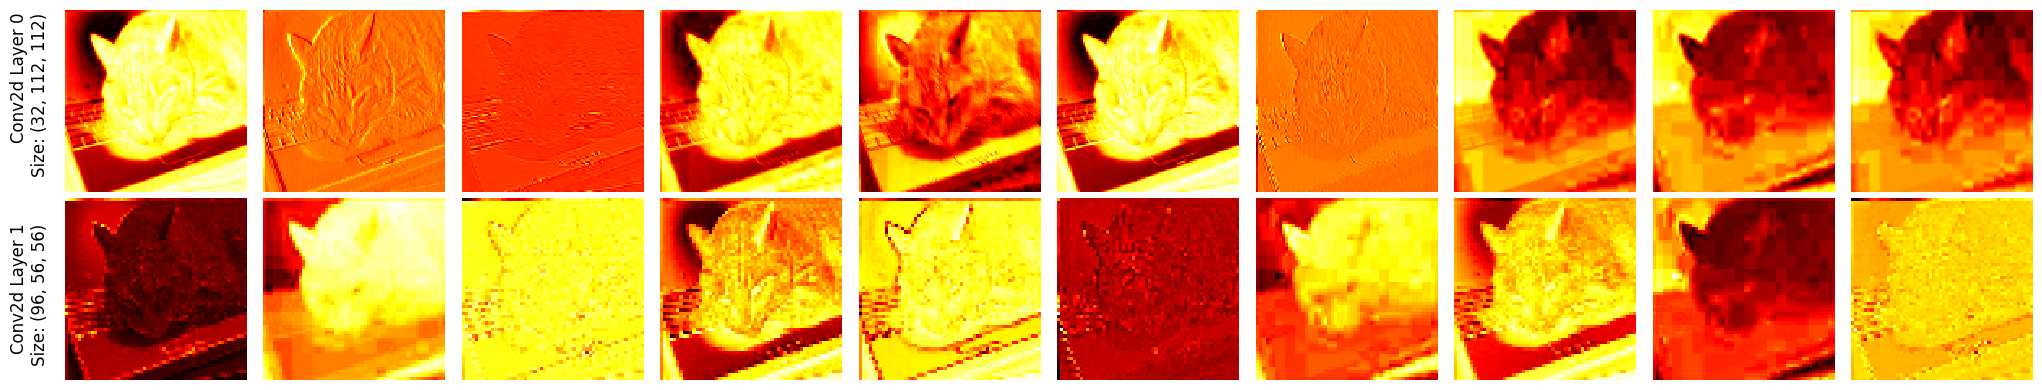

In [27]:
#print first k layer

# Set the number of layers to be printed and the number of pictures per layer
k = 2  # Number of layers to plot
n = 10   # Number of feature maps to plot per layer

# Determine the number of layers to plot (minimum of k and total layers available)
num_layers = min(k, len(feature_maps))

# Create subplots
fig, axs = plt.subplots(num_layers, n, figsize=(n * 2, num_layers * 2))

# Plot the feature maps
for idx in range(num_layers):  # Only loop through the first k layers
    layer_name, layer_map = feature_maps[idx]
    num_filters = min(n, layer_map.shape[1])  # Get the smaller value between n and the number of filters
    for i in range(num_filters):  # Only plot the first n filters of each layer
        filter_map = layer_map[0, i]  # Get the i-th filter map of the first example
        if num_layers == 1:
            ax = axs[i]  # Use axs directly if there's only one row
        else:
            ax = axs[idx, i]  # Use axs with two indices otherwise
        ax.imshow(filter_map, cmap='hot', interpolation='nearest')
        ax.axis('off')

    # Add layer name on the left of each row
    if num_layers > 1:
        fig.text(0, 1 - (idx + 0.5) / num_layers, f"{layer_name} Layer {idx}\nSize: {layer_map[0].shape}", 
                 va='center', ha='right', rotation='vertical', fontsize=12)

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig("output.jpeg", dpi=300)
plt.show()

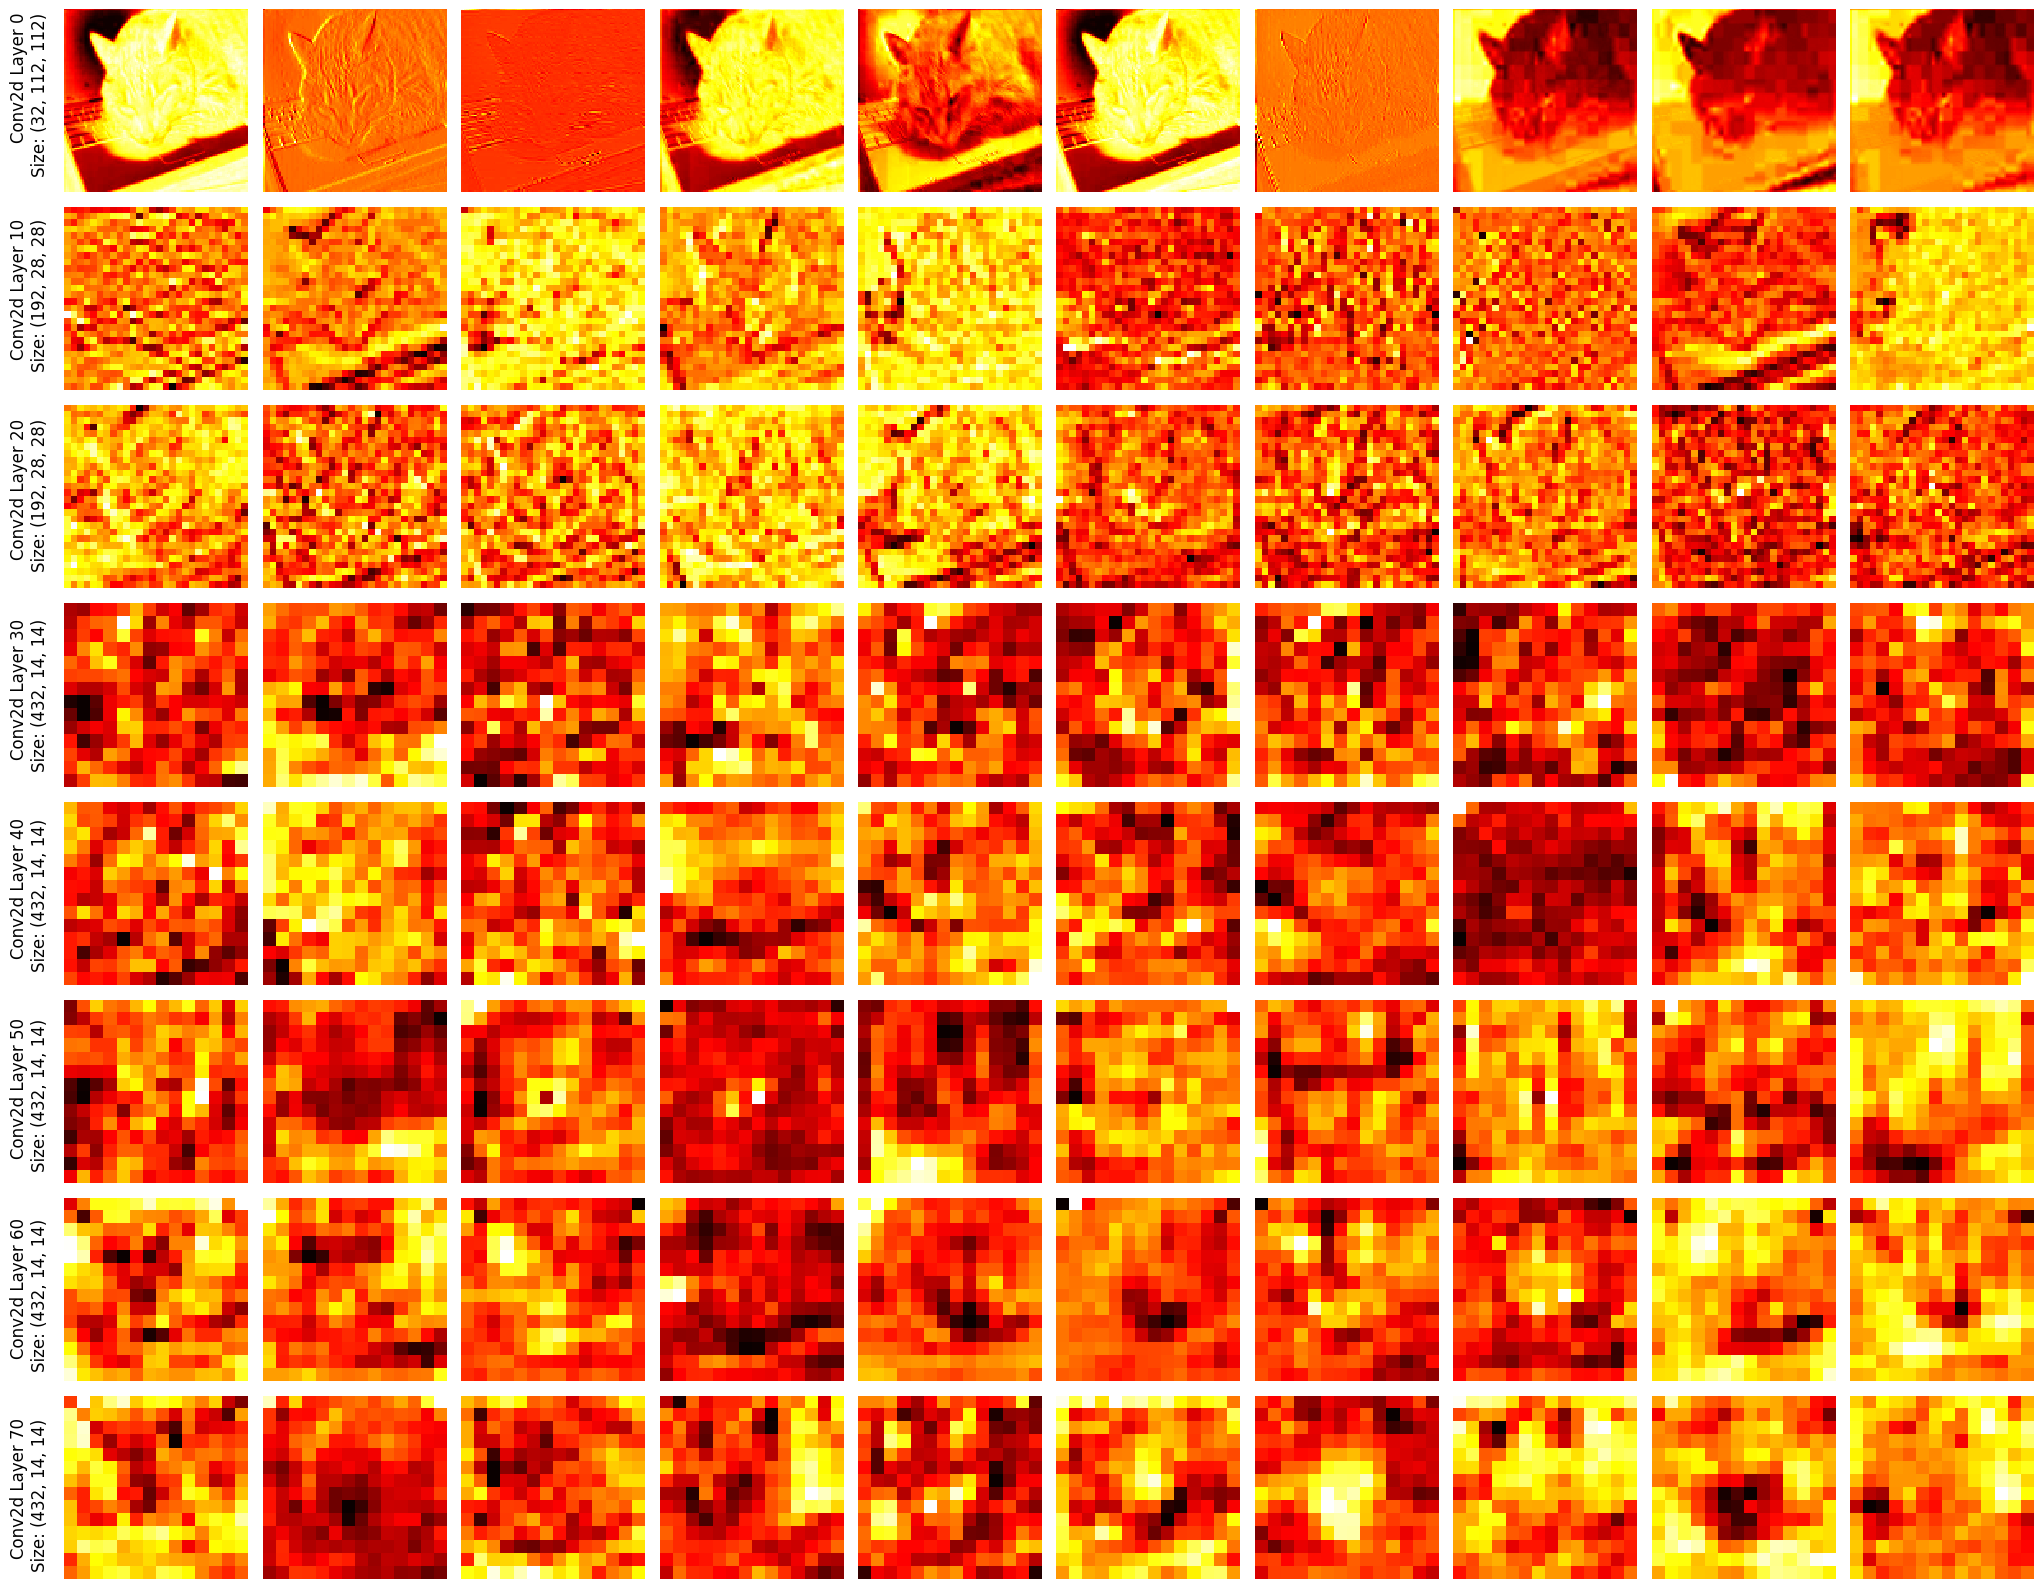

In [32]:
# Set the layer frequency and the number of pictures to be printed
k = 10  # Layer number
n = 10  # Number of pictures

# Initialize counter
counter = 0
num_layers = len(feature_maps) // k

fig, axs = plt.subplots(num_layers, n, figsize=(n * 2, num_layers * 2))

# Plot the feature maps
for idx, (layer_name, layer_map) in enumerate(feature_maps):
    
    if counter % k == 0:  # Only plot if the layer index is k
        num_filters = min(n, layer_map.shape[1])  # Get the smaller value between n and the number of filters
        for i, filter_map in enumerate(layer_map[0][:num_filters]):  # Only plot the first n filters
            axs[counter // k, i].imshow(filter_map, cmap='hot', interpolation='nearest')
            axs[counter // k, i].axis('off')
        
        # Add layer name on the left of each row
        fig.text(0, 1 - (counter // k + 0.5) / (num_layers ), f"{layer_name} Layer {counter}\nSize: {layer_map[0].shape}", 
                 va='center', ha='right', rotation='vertical', fontsize=12)

    counter += 1
    
# Display the plot
plt.tight_layout()
plt.savefig("output.jpeg", dpi=300)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


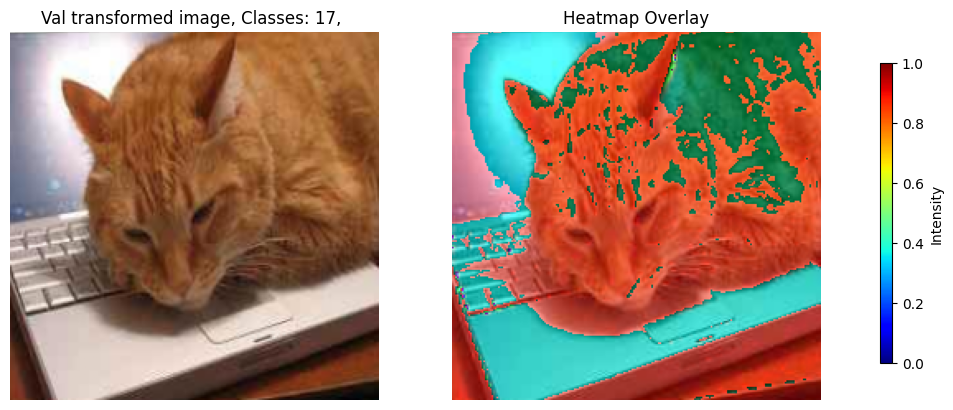

In [23]:
from torch.nn import functional as F
import torch
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt

image_number = 4

# Get one batch of training data
images, labels = next(iter(val_loader))

# Only select one image from the batch
image_torch = images[image_number]
image_torch_input = image_torch.unsqueeze(0)  # Add an extra dimension for the batch size
label = labels[image_number]


# Since the images are normalized, we need to denormalize to plot them
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
image = image_torch.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
image = image * std + mean  # Denormalize
image = image.numpy()

#print(f'label string: {label}')

def grad_cam(model, image, target_layer, target_class=None):
    model.eval()
    gradients = []
    feature_maps = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    def forward_hook(module, input, output):
        feature_maps.append(output.detach())

    # Use register_full_backward_hook instead of register_backward_hook
    hook_f = target_layer.register_forward_hook(forward_hook)
    hook_b = target_layer.register_backward_hook(backward_hook)  # Updated line

    output = model(image)
    if target_class is None:
        target_class = torch.argmax(output)

    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()

    hook_f.remove()
    hook_b.remove()

    gradients = gradients[0]
    feature_maps = feature_maps[0]
    weights = torch.mean(gradients, dim=[2, 3], keepdim=True)
    grad_cam_map = torch.sum(weights * feature_maps, dim=1)[0]
    grad_cam_map = F.relu(grad_cam_map)
    grad_cam_map = grad_cam_map ** 2  # Apply non-linear scaling to enhance contrast
    grad_cam_map = grad_cam_map / torch.max(grad_cam_map)  # Normalize
    grad_cam_map = grad_cam_map.numpy()
    
    return grad_cam_map

# Select the layer to visualize and prepare your model and input image accordingly
target_layer = model.stem

cam_heatmap = grad_cam(model, image_torch_input, target_layer)

heatmap_resized = np.uint8(255 * cam_heatmap)  # Convert to uint8
heatmap_resized = np.array(Image.fromarray(heatmap_resized).resize((image.shape[1], image.shape[0]), Image.BILINEAR))

heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
superimposed_img = heatmap_color * 0.7 + np.uint8(255 * image) 

#title for input image
title = 'Val transformed image, Classes: '
for i, class_value in enumerate(label):
    if class_value == 1:
        # Extract the class name from the column name
        class_name = df_encoded_train.columns[i+1]
        class_number = class_name.split('_')[1] 
        title += f'{class_number}, '

# Creating subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# Original image
axes[0].imshow(image)
axes[0].set_title(title)
axes[0].axis('off')

# Heatmap overlay
heatmap_display = axes[1].imshow(superimposed_img.astype('uint8'))
axes[1].set_title('Heatmap Overlay')
axes[1].axis('off')

# Manually adjusting the position of subplots to give more space for the colorbar
fig.subplots_adjust(right=0.8)

# Adding a colorbar, specifying the size ("shrink") and padding ("pad")
cbar_ax = fig.add_axes([0.85, 0.25, 0.01, 0.5])  # [left, bottom, width, height]
cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='jet'), cax=cbar_ax)
cbar.set_label('Intensity')

plt.show()